# Imports

In [1]:
# base
import numpy as np
import pkg_resources
from sklearn.impute import SimpleImputer
from pandas_plink import read_plink
import math
import statsmodels.api as sm

# viz
import matplotlib.pyplot as plt
from matplotlib import gridspec
import cartopy.crs as ccrs

# feems
from feems.utils import prepare_graph_inputs
from feems import SpatialGraph, Viz
from feems.cross_validation import run_cv
from feems.objective import comp_mats
from joint_ver import Joint_SpatialGraph, Joint_Objective

# change matplotlib fonts
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.sans-serif"] = "Arial"

# Data

In [2]:
data_path = pkg_resources.resource_filename("feems", "data/")

# read the genotype data and mean impute missing data
(bim, fam, G) = read_plink("{}/wolvesadmix".format(data_path))
imp = SimpleImputer(missing_values=np.nan, strategy="mean")
genotypes = imp.fit_transform((np.array(G)).T)

# setup graph
coord = np.loadtxt("{}/wolvesadmix.coord".format(data_path))  # sample coordinates
outer = np.loadtxt("{}/wolvesadmix.outer".format(data_path))  # outer coordinates
grid_path = "{}/grid_100.shp".format(data_path)  # path to discrete global grid

# graph input files
outer, edges, grid, _ = prepare_graph_inputs(coord=coord, 
                                             ggrid=grid_path,
                                             translated=True, 
                                             buffer=0,
                                             outer=outer)

# construct spatial graph object 
sp_graph = Joint_SpatialGraph(genotypes, coord, grid, edges, scale_snps=True)

Mapping files: 100%|██████████| 3/3 [00:00<00:00, 19.49it/s]


# Visualize

## FEEMS fits

constant-w/variance fit, converged in 132 iterations, train_loss=2795677.6543430


/project2/jnovembre/jhmarcus/src/miniconda3/envs/feems_analysis_e/lib/python3.8/site-packages/feems/objective.py:176: RuntimeWarning: divide by zero encountered in log
  nll = self.sp_graph.n_snps * (self.tr - np.log(self.det))


lambda=2.0691381, alpha=0.8354260, converged in 48 iterations, train_loss=2767773.0046874
constant-w/variance fit, converged in 132 iterations, train_loss=2795677.6543430
lambda=2.0691381, alpha=0.8354260, converged in 156 iterations, train_loss=2747317.4422620
CPU times: user 11 s, sys: 20.9 ms, total: 11 s
Wall time: 11.4 s


Text(0.67, 0.83, 'C')

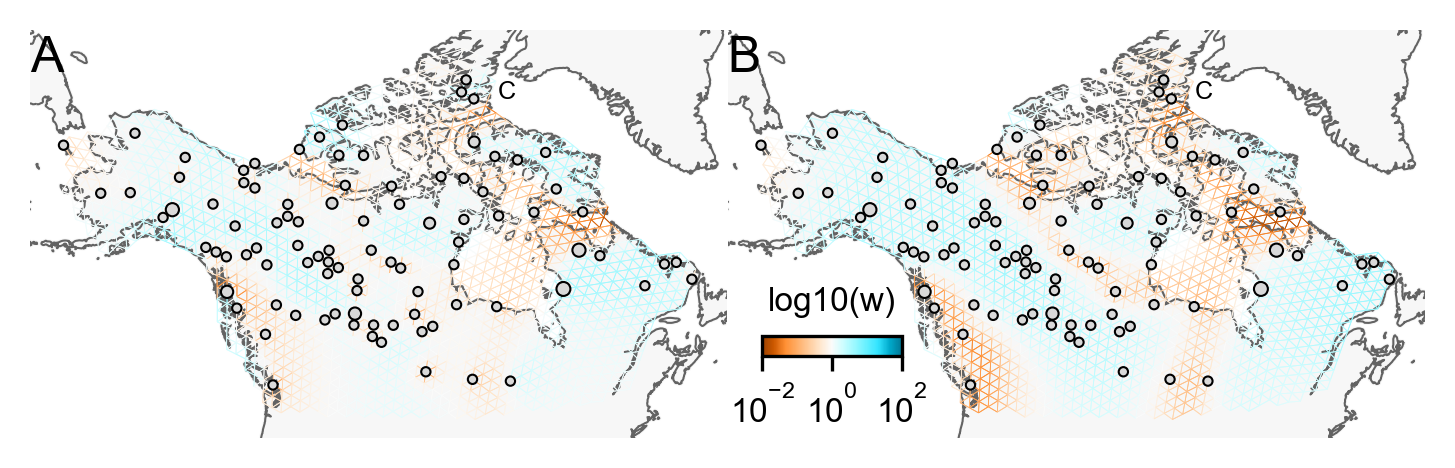

In [3]:
%%time
# figure params
projection = ccrs.EquidistantConic(central_longitude=-108.842926, central_latitude=66.037547)
title_loc = "left"
title_pad = "-10"
title_fontsize = 12
edge_width = .2
edge_alpha = 1
edge_zorder = 3
obs_node_size = 5
obs_node_linewidth = .4
cbar_font_size = 8
cbar_ticklabelsize = 8
cbar_orientation = "horizontal"

# figure setup
fig = plt.figure(dpi=300)
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig, wspace=0.0, hspace=0.0)

# axis 00 
ax_00 = fig.add_subplot(spec[0, 0], projection=projection)
ax_00.set_title("A", loc=title_loc, pad=title_pad, fontdict={"fontsize": title_fontsize})
lamb = 2.06913808111479 # use optimal lambda from leave-one-out CV in Figure 3&4
sp_graph.fit(lamb=lamb,
             optimize_q="1-dim", 
             lamb_q=0.0, 
             alpha_q=0.0, 
             lb=math.log(1e-6), 
             ub=math.log(1e+6))
v = Viz(ax_00, sp_graph, projection=projection, edge_width=edge_width, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, 
        obs_node_size=obs_node_size, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_map()
v.draw_edges(use_weights=True)
v.draw_obs_nodes(use_ids=False) 
ax_00.text(.67, .83, "C", fontdict={"fontsize": 6}, transform = ax_00.transAxes)

# axis 01
ax_01 = fig.add_subplot(spec[0, 1], projection=projection)
ax_01.set_title("B", loc=title_loc, pad=title_pad, fontdict={"fontsize": title_fontsize})
lamb = 2.06913808111479 # use optimal lambda from leave-one-out CV in Figure 3&4
sp_graph.fit(lamb=lamb,
             optimize_q="n-dim", 
             lamb_q=1.0, 
             alpha_q=1.0, 
             lb=math.log(1e-6), 
             ub=math.log(1e+6))
v = Viz(ax_01, sp_graph, projection=projection, edge_width=edge_width, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, 
        obs_node_size=obs_node_size, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_map()
v.draw_edges(use_weights=True)
v.draw_obs_nodes(use_ids=False)
v.cbar_font_size = cbar_font_size
v.cbar_orientation = cbar_orientation
v.cbar_ticklabelsize = cbar_ticklabelsize
v.draw_edge_colorbar()
ax_01.text(.67, .83, "C", fontdict={"fontsize": 6}, transform = ax_01.transAxes)

In [5]:
fig.savefig(
    "../../output/figures/supp-figure-13-joint-est.pdf", bbox_inches="tight", pad_inches=.1
)

## Goodness of fits

In [6]:
def cov_to_dist(S):
    s2 = np.diag(S).reshape(-1, 1)
    ones = np.ones((s2.shape[0], 1))
    D = s2 @ ones.T + ones @ s2.T - 2 * S
    return(D)

constant-w/variance fit, converged in 132 iterations, train_loss=2795677.6543430
lambda=2.0691381, alpha=0.8354260, converged in 82 iterations, train_loss=2767305.7245924
constant-w/variance fit, converged in 132 iterations, train_loss=2795677.6543430
lambda=2.0691381, alpha=0.8354260, converged in 156 iterations, train_loss=2747317.4422620


Text(0, 0.5, 'genetic distance')

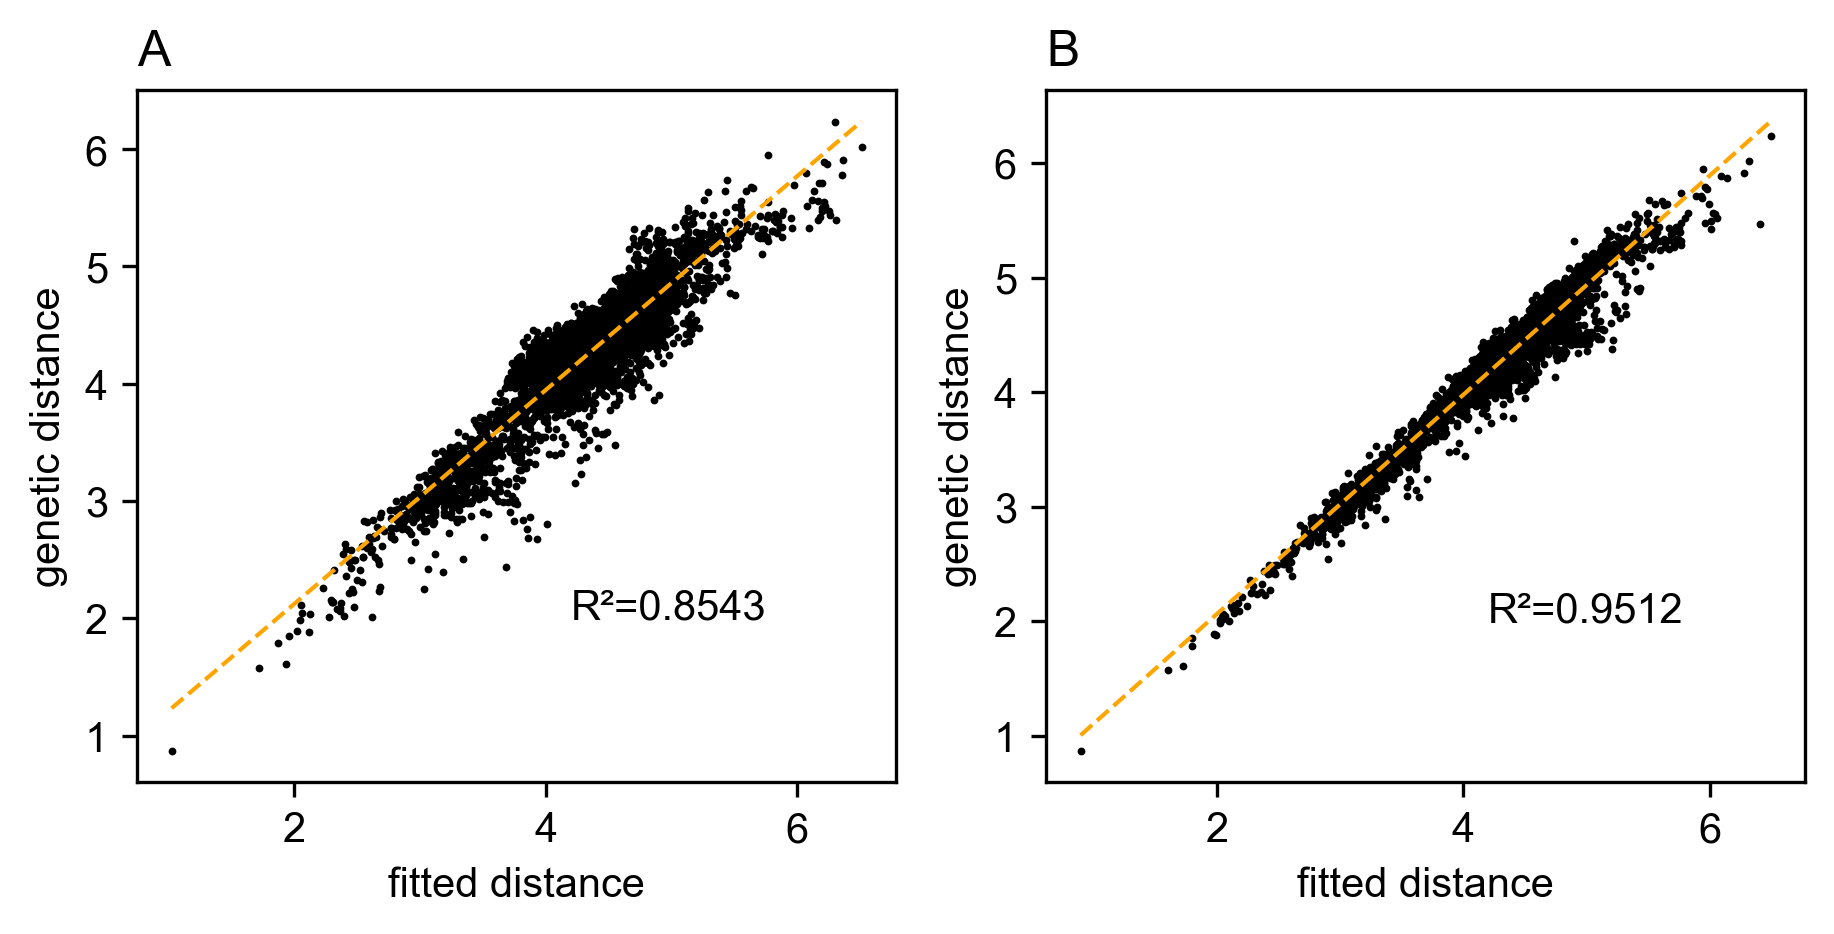

In [7]:
fig = plt.figure(constrained_layout=True, dpi=300, figsize=(6,3))
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

# (A)
tril_idx = np.tril_indices(sp_graph.n_observed_nodes, k=-1)
ax_00 = fig.add_subplot(spec[0, 0])
ax_00.set_title("A", loc='left')

# fit feems while holding residual variance fixed
sp_graph.fit(lamb=lamb,
             lb=math.log(1e-6), 
             ub=math.log(1e+6))
sp_graph.comp_graph_laplacian(sp_graph.w)

# create obj instance
obj = Joint_Objective(sp_graph)
fit_cov, _, emp_cov = comp_mats(obj)
fit_dist = cov_to_dist(fit_cov)[tril_idx]
emp_dist = cov_to_dist(emp_cov)[tril_idx]
X = sm.add_constant(fit_dist)
mod = sm.OLS(emp_dist, X)
res = mod.fit()
muhat, betahat = res.params
ax_00.scatter(fit_dist,
              emp_dist,
              marker=".", 
              alpha=1, 
              zorder=0, 
              color="black",
              s=3)

x_ = np.linspace(np.min(fit_dist), np.max(fit_dist), 20)
ax_00.plot(x_, muhat + betahat * x_, zorder=2, color="orange", linestyle='--', linewidth=1)
ax_00.text(4.2, 2, "R²={:.4f}".format(res.rsquared))
ax_00.set_xlabel("fitted distance")
ax_00.set_ylabel("genetic distance")


# (B)
tril_idx = np.tril_indices(sp_graph.n_observed_nodes, k=-1)
ax_01 = fig.add_subplot(spec[0, 1])
ax_01.set_title("B", loc='left')

# fit feems while holding residual variance fixed
sp_graph.fit(lamb=lamb,
             optimize_q="n-dim", 
             lamb_q=1.0, 
             alpha_q=1.0, 
             lb=math.log(1e-6), 
             ub=math.log(1e+6))
sp_graph.comp_graph_laplacian(sp_graph.w)

# create obj instance
obj = Joint_Objective(sp_graph)
fit_cov, _, emp_cov = comp_mats(obj)
fit_dist = cov_to_dist(fit_cov)[tril_idx]
emp_dist = cov_to_dist(emp_cov)[tril_idx]
X = sm.add_constant(fit_dist)
mod = sm.OLS(emp_dist, X)
res = mod.fit()
muhat, betahat = res.params
ax_01.scatter(fit_dist,
              emp_dist,
              marker=".", 
              alpha=1, 
              zorder=0, 
              color="black",
              s=3)

x_ = np.linspace(np.min(fit_dist), np.max(fit_dist), 20)
ax_01.plot(x_, muhat + betahat * x_, zorder=2, color="orange", linestyle='--', linewidth=1)
ax_01.text(4.2, 2, "R²={:.4f}".format(res.rsquared))
ax_01.set_xlabel("fitted distance")
ax_01.set_ylabel("genetic distance")

In [9]:
fig.savefig(
    "../../output/figures/supp-figure-14-joint-est-gof.pdf", bbox_inches="tight", pad_inches=.1
)